In [2]:
import sys

sys.path.append("/Users/Mike/desktop/UCSB/CS/CS111/cs111-2021-fall/Python") 

import os
import time
import math
import numpy as np
import numpy.linalg as npla
import scipy
from scipy import linalg as spla
import scipy.sparse
import scipy.sparse.linalg
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import cs111

%matplotlib inline

np.set_printoptions(precision = 4)

In [587]:
#cs111.Lsolve()
def Lsolve(L, b, unit_diag=False):
    """Forward solve a unit lower triangular system Ly = b for y
    Parameters: 
      L: the matrix, must be square, lower triangular, with ones on the diagonal
      b: the right-hand side vector
      unit_diag: if True, assume the diagonal is all ones
    Output:
      y: the solution vector to L @ y == b
    """
    
    # Check the input
    m, n = L.shape
    assert m == n, "matrix L must be square"
    assert np.all(np.tril(L) == L), "matrix L must be lower triangular"
    if unit_diag:
        assert np.all(np.diag(L) == 1), "matrix L must have ones on the diagonal"
    
    # Make a copy of the rhs that we will transform into the solution
    assert b.ndim == 1, "right-hand side must be a 1-dimensional vector"
    assert b.shape[0] == n, "right-hand side must be same size as matrix"
    y = b.astype(np.float64).copy()
    
    # Forward solve
    for col in range(n):
        if not unit_diag:
            y[col] /= L[col, col]
        y[col+1:] -= y[col] * L[col+1:, col]
        
    return y

In [588]:
#cs111.Usolve()
def Usolve(U, y, unit_diag=False):
    """Backward solve an upper triangular system Ux = y for x
    Parameters: 
      U: the matrix, must be square, upper triangular, with nonzeros on the diagonal
      y: the right-hand side vector
      unit_diag: if True, assume the diagonal is all ones
    Output:
      x: the solution vector to U @ x == y
    """
    # Check the input
    m, n = U.shape
    assert m == n, "matrix must be square"
    assert np.all(np.triu(U) == U), "matrix U must be upper triangular"
    if unit_diag:
        assert np.all(np.diag(U) == 1), "matrix U must have ones on the diagonal"

    # Make a copy of the rhs that we will transform into the solution
    assert y.ndim == 1, "right-hand side must be a 1-dimensional vector"
    assert y.shape[0] == n, "right-hand side must be same size as matrix"
    x = y.astype(np.float64).copy()

    # Back solve
    for col in reversed(range(n)):
        if not unit_diag:
            x[col] /= U[col, col]
        x[:col] -= x[col] * U[:col, col]
        
    return x

When solving $Ax=b$, we used $(PA=LU)\Rightarrow(A=P^TLU)$ to substitute: $$Ax=b \Rightarrow (P^TLU)x=b \Rightarrow LUx=Pb$$ Then we set $y=Ux \text{ and solved }Ly=Pb \text{ by using }$ $$y = Lsolve(L,b[p])$$After, we got our solution by using $$x=Usolve(U,y)$$Now we're solving $A^Tx=b$Transpose both sides $$(LU=PA) \Rightarrow ((LU)^{T}=(PA)^{T})$$Simplify$$\Rightarrow U^{T}L^{T}=A^{T}P^{T}$$$$\Rightarrow A^T = U^TL^TP$$Substituting $$A^Tx=b\Rightarrow (U^TL^TP)x=b$$ we have $$U^T(L^TPx)=b$$

## Homework 3 
## Problem 1

In [7]:
A = np.random.rand(6,6)
b = np.random.rand(6)
print("A: \n", A)
print("\nb: \n", b)

L, U, p = cs111.LUfactor(A)
Ptrans = np.eye(len(p))[p,:].T # create matrix P from p, tranpose it
pinv = np.array(np.where(Ptrans[:,:]==1))[1] # find pinv

y = cs111.Lsolve(U.T,b)
d = cs111.Usolve(L.T,y,unit_diag=True)
x = d[pinv] #permute the final answer
res = npla.norm(b - A.T@x) / npla.norm(b) #relative res norm
print("\nx: \n", x)
print("\nrelative residual norm =\n", res)

A: 
 [[0.4674 0.9857 0.3668 0.6576 0.767  0.7292]
 [0.9739 0.4032 0.0443 0.6854 0.7587 0.9184]
 [0.5428 0.4715 0.091  0.4718 0.7177 0.4702]
 [0.7252 0.8702 0.1897 0.0736 0.5873 0.8138]
 [0.84   0.3914 0.7607 0.488  0.3282 0.7324]
 [0.8315 0.2754 0.9995 0.6815 0.8485 0.4152]]

b: 
 [0.7463 0.592  0.3302 0.7511 0.8578 0.9784]

x: 
 [ 1.4841  2.3734 -4.057   0.4919 -1.8213  1.343 ]

relative residual norm =
 5.384326597898874e-16


## Problem 2

We have this linear system:
$$\begin{pmatrix}
\alpha & 1\\
1 & 1
\end{pmatrix}\begin{pmatrix}
x_0\\
x_1
\end{pmatrix}=\begin{pmatrix}
1-\alpha\\
0
\end{pmatrix}\text{ for some }\alpha < 1.$$

In [146]:
alpha = np.array([10.0**(-4.0), 10.0**(-8.0), 
                  10.0**(-12.0), 10.0**(-16.0), 10.0**(-20.0)])
x_exact = np.array([-1,1])

print("PART ONE")
for j in np.array([True, False]):
    print("\n\nPivoting = ", j, "\n\n")
    for i in alpha:
        print("alpha = ", i)
        A = np.array([[i,1],[1,1]])
        b = np.array([1-i,0])
        ans, res = cs111.LUsolve(A,b,pivoting=j)
        error = x_exact - ans
        print("condition number of A = ", npla.cond(A,2))
        print("computed x = ", ans)
        print("norm of the error = ", npla.norm(error))
        print("relative residual norm = ", res, "\n")
        
print("PART TWO")
for j in np.array([True, False]):
    print("\n\nPivoting = ", j, "\n\n")
    for i in alpha:
        print("alpha = ", i)
        A = np.array([[1+i,1],[1,1]])
        b = np.array([-i,0])
        print("condition number of A = ", npla.cond(A,2))
        try:
            ans, res = cs111.LUsolve(A,b,pivoting=j)
            error = x_exact - ans
            print("computed x = ", ans)
            print("norm of the error = ", npla.norm(error))
            print("relative residual norm = ", res, "\n")
        except:
            print("Answer not returned \n")

PART ONE


Pivoting =  True 


alpha =  0.0001
condition number of A =  2.618385273654827
computed x =  [-1.  1.]
norm of the error =  0.0
relative residual norm =  0.0 

alpha =  1e-08
condition number of A =  2.618034023874506
computed x =  [-1.  1.]
norm of the error =  0.0
relative residual norm =  0.0 

alpha =  1e-12
condition number of A =  2.618033988753407
computed x =  [-1.  1.]
norm of the error =  0.0
relative residual norm =  0.0 

alpha =  1e-16
condition number of A =  2.6180339887498953
computed x =  [-1.  1.]
norm of the error =  0.0
relative residual norm =  0.0 

alpha =  1e-20
condition number of A =  2.6180339887498953
computed x =  [-1.  1.]
norm of the error =  0.0
relative residual norm =  0.0 



Pivoting =  False 


alpha =  0.0001
condition number of A =  2.618385273654827
computed x =  [-1.  1.]
norm of the error =  1.1013412404281553e-13
relative residual norm =  1.1014513855667119e-13 

alpha =  1e-08
condition number of A =  2.618034023874506
computed x =

In [165]:
A = np.array([[1,1],[1,1]])
print(A)
L, U, p = cs111.LUfactor(A)

[[1 1]
 [1 1]]


AssertionError: can't find nonzero pivot, matrix is singular

## Problem 3

In [172]:
def make_A_3D(k):
    triples = []
    for x in range(k):
        for y in range(k):
            for z in range(k)
                row = x + k*y + k*k*z # row for grid point (x,y,z)
                col = row
                triples.append((row, col, 6.0)) # diagonal elements
                
                # x dimension
                if x > 0:
                    col = row - 1
                    triples.append((row, col, -1.0))
                if x < k - 1:
                    col = row + 1
                    triples.append((row, col, -1.0))
                    
                # y dimension
                if y > 0:
                    col = row - k
                    triples.append((row, col, -1.0))
                if y < k - 1:
                    col = row + k
                    triples.append((row, col, -1.0))
                    
                # z dimension
                if z > 0:
                    col = row - k*k
                    triples.append((row, col, -1.0))
                if z < k - 1:
                    col = row + k*k
                    triples.append((row, col, -1.0))

    ndim = k*k*k # 3 dimensions
    rownum = [t[0] for t in triples]
    colnum = [t[1] for t in triples]
    values = [t[2] for t in triples]
    
    A = scipy.sparse.csr_matrix((values, (rownum, colnum)), shape = (ndim, ndim))
    return A

k: 4
dimensions: (64, 64)
nonzeros: 352


(0.0, 30.0, 30.0, 0.0)

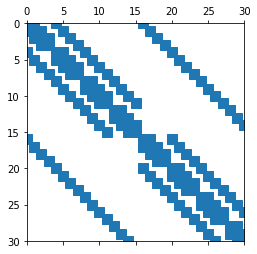

In [189]:
k = 4
A = make_A_3D(k)
print("k:", k)
print("dimensions:", A.shape)
print("nonzeros:", A.nnz)
#print("A as sparse matrix:\n", A)
#print("A as dense matrix:\n", A.toarray())
plt.spy(A)
x_min = 0
x_max = 30
y_min = 30
y_max = 0
plt.axis([x_min, x_max, y_min, y_max])

In [6]:
A = np.array([[2,-2],[0,2]])
b = np.array([1,1])
x = np.array([2,1])

residual = b-A@x
residual
print("\n")
res_norm = npla.norm(b - A@x) / npla.norm(b)
res_norm

1.0